In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_with_adjoint_accel as nddde
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDistDDE_args(nddde.nddde_arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1, nn_d1 = 0., nn_d2 = 0.5, adj_data_size = 2,
                 model_dir = 'Bio_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2000., nt = 4000, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                 Xi = 0.1, R_m = 1., Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30, 
                 bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3
        elif bio_model_low_complex == 'NPZD': state_dim = 4
        elif bio_model_low_complex == 'NNPZD': state_dim = 5

        nddde.nddde_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, nn_d1 = nn_d1,
                           nn_d2 = nn_d2, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_low_complex)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the neural net architecture

In [5]:
class BioConstrainLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        
        super(BioConstrainLayer, self).__init__(**kwargs)
        
        self.gamma = tf.Variable(0.1, trainable=True, constraint = self.constraint)
        
    def constraint(self, gamma):
        
        out = tf.where(gamma <= 1., tf.where(gamma >= 0., gamma, 0.), 1.)
        
        return out
        
        
    def call(self, input):
        
        N_channel = self.gamma * input
        P_channel = - input
        Z_channel = (1. - self.gamma) * input
        
        output = tf.concat([N_channel, P_channel, Z_channel], axis=-1)
        
        return output

In [6]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim - 2, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.bio = BioConstrainLayer()

    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z = self.pass_layers(z)
        
        return z

In [7]:
class DDEFuncAux(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncAux, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

        self.out = tf.keras.layers.Dense(4, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z = self.pass_layers(z)
        
        return z

In [8]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def __call__(self, t):
        return self.zy(t)[:, :self.args.state_dim]

In [9]:
class DistDDEFunc(tf.keras.Model):

    def __init__(self, main, aux, rom_model, args, **kwargs):
        super(DistDDEFunc, self).__init__(**kwargs)
        self.main = main
        self.aux = aux
        self.rom_model = rom_model
        self.args = args

    def process_input(self, y, t ,d):     
        
        input = [y(t)]
        input.append(y(t - d[0])[:, :self.args.state_dim])
        input.append(y(t - d[1])[:, :self.args.state_dim])
        
        return input
    
    def call_nn_part(self, input):
        dz_dt = self.main(input[0])
        gz_t1 = self.aux(input[1])
        gz_t2 = self.aux(input[2])
        dy_dt = gz_t1 - gz_t2
        
        return tf.concat([dz_dt, dy_dt], axis=-1)

    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        get_z = split_zy(y, self.args)       
        
        input = self.process_input(y, t ,d)
        dzy_dt = self.call_nn_part(input)
        
        rom_output = self.rom_model(get_z, t, t_start)
        rom_output = tf.concat([rom_output, tf.zeros([dzy_dt.shape[0], dzy_dt.shape[1] - rom_output.shape[1]])], axis=-1)
        
        dzy_dt = dzy_dt + rom_output
        
        return dzy_dt

### Define a custom plotting function

In [10]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(20, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=18)
        ax_x1.set_xlabel('t (Days)', fontsize=18)
        ax_x1.set_ylabel('Concentration', fontsize=18)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], '-r', label = 'N (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 0], '-.r', label = 'N (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], '--r', label = 'N (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 1], '-g', label = 'P (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 1], '-.g', label = 'P (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 1], '--g', label = 'P (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 2], '-b', label = 'Z (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 2], '-.b', label = 'Z (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 2], '--b', label = 'Z (Learned)')

        ax_x1.set_xlim(self.t[0], self.t[-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

        plt.show() 

### Initialize model related parameters

In [108]:
args = bio_eq_nDistDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 4, epochs = 350, learning_rate = 0.05, 
                            decay_rate = 0.97, test_freq = 1, plot_freq = 1, d_max = 5., nn_d1 = 0., nn_d2 = 2.5, 
                            model_dir = 'Bio_nDistDDE_testcase_v3/model_dir_case13g', restart = 0, val_percentage = 10.,
                            T = 30., nt = 600, z = -25, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., 
                            Psi = 1.46, Xi = 0.1, R_m = 1.52, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, 
                            Omega = 0.041, T_bio = 30., bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', 
                            ode_alg_name = 'dopri5', nsteps = 5)

### Make a copy of the current script

In [109]:
testcase_dir = 'neuralClosureModels/testcases/Bio_Eqn'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Solve for the high complexity model

In [13]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

/home/abhinavgupta0110/.local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Higher complexity model done!


## Main part starts here

### Make objects and define learning-rate schedule

In [110]:
func_main = DDEFuncMain()
func_aux = DDEFuncAux()
rom_model = bio.bio_eqn(app = args)
func = DistDDEFunc(func_main, func_aux, rom_model, args)

### Quick test to see how the true coefficients looks like

In [111]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
process_true_z0 = nddde.process_DistDDE_IC(x0_low_complex, func_aux, t_lowerlim = t[0] - args.nn_d2, t_upperlim = t[0] - args.nn_d1)
pred_zy = ddeinttf(func, process_true_z0, tf.concat([t, val_t], axis=0), fargs=([args.nn_d1, args.nn_d2],), alg_name = args.ode_alg_name, nsteps = args.nsteps)

pred_y = pred_zy[:, :, :args.state_dim]

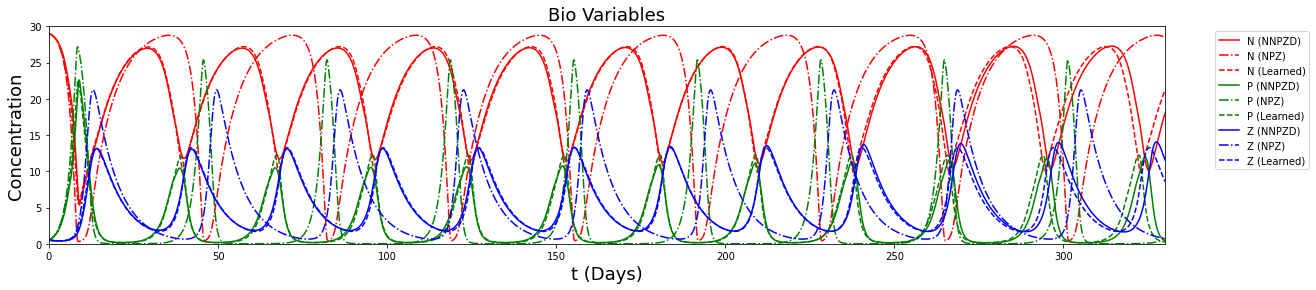

In [112]:
plot_obj = custom_plot(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_y)

### Print the network architecture

In [113]:
func_main.summary()

Model: "dde_func_main_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             multiple                  56        
_________________________________________________________________
dense_73 (Dense)             multiple                  56        
_________________________________________________________________
dense_74 (Dense)             multiple                  8         
_________________________________________________________________
bio_constrain_layer_12 (BioC multiple                  1         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [114]:
func_aux.summary()

Model: "dde_func_aux_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             multiple                  20        
_________________________________________________________________
dense_76 (Dense)             multiple                  30        
_________________________________________________________________
dense_77 (Dense)             multiple                  24        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


In [115]:
os.chdir(basedir)

data_dict = {'true_x_low_complex':true_x_low_complex, 'val_true_x_low_complex':val_true_x_low_complex,
             'x_low_complex':x_low_complex, 'val_x_low_complex':val_x_low_complex, 'pred_y': pred_y, 't': t, 'val_t': val_t}

with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDistDDE_C13g_Exp3_predictions.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)